# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.Define the model class.

In [2]:
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(no_hidden,no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

#### Divide the dataset into a 80:20 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

2.Split the dataset and do preprocessing.

In [3]:
from common_utils import split_dataset, preprocess_dataset

def preprocess(df):
    X_train, y_train, X_test, y_test = split_dataset(df, ["filename", "label"], 0.2, 0)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

    print(f"Total df: {len(df)}")
    print(f"x_train: {len(X_train)}, y_train: {len(y_train)}, X_test: {len(X_test)}, y_test: {len(y_test)}")
    print(f"X_train_scaled: {len(X_train_scaled)}, X_test_scaled: {len(X_test_scaled)}")
    
    return X_train_scaled, y_train, X_test_scaled, y_test
    
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

Total df: 12057
x_train: 9645, y_train: 9645, X_test: 2412, y_test: 2412
X_train_scaled: 9645, X_test_scaled: 2412


#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

3.Define a Pytorch Dataset and Dataloaders.  

In [4]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float).unsqueeze(1)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    train_data = CustomDataset(X_train_scaled, y_train)
    test_data = CustomDataset(X_test_scaled, y_test)

    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)
    
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

4.Next, define the model, optimizer and loss function.

In [5]:
no_features = 77
no_hidden = 128
no_labels = 1

lr = 0.001

model = MLP(no_features, no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = nn.BCELoss()

5.Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [6]:
from common_utils import EarlyStopper

epochs = 100
early_stopper = EarlyStopper(patience=3, min_delta=0)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += torch.sum(torch.eq(pred > 0.5, y.clone().detach()))

    train_loss /= num_batches
    train_correct = train_correct.float() /size

    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, test_correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += torch.sum(torch.eq(pred > 0.5, y.clone().detach()))
        test_loss /= num_batches
        test_correct = test_correct.float()/size

    return test_loss, test_correct

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
for t in range(epochs):
    train_loss, train_correct = train_loop(train_dataloader, model,loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)

    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")


    if early_stopper.early_stop(test_loss):
        break


Epoch 1: Train_accuracy: 55.86%, Train_loss: 0.684075, Test_accuracy: 56.14%, Test_loss: 0.678396
Epoch 2: Train_accuracy: 59.39%, Train_loss: 0.665208, Test_accuracy: 57.59%, Test_loss: 0.680145
Epoch 3: Train_accuracy: 61.90%, Train_loss: 0.649608, Test_accuracy: 60.61%, Test_loss: 0.661482
Epoch 4: Train_accuracy: 64.31%, Train_loss: 0.632042, Test_accuracy: 62.40%, Test_loss: 0.654664
Epoch 5: Train_accuracy: 65.81%, Train_loss: 0.616410, Test_accuracy: 64.68%, Test_loss: 0.634549
Epoch 6: Train_accuracy: 68.19%, Train_loss: 0.593194, Test_accuracy: 64.72%, Test_loss: 0.636102
Epoch 7: Train_accuracy: 69.38%, Train_loss: 0.575457, Test_accuracy: 65.63%, Test_loss: 0.618358
Epoch 8: Train_accuracy: 70.44%, Train_loss: 0.561540, Test_accuracy: 66.38%, Test_loss: 0.620660
Epoch 9: Train_accuracy: 72.09%, Train_loss: 0.537987, Test_accuracy: 65.63%, Test_loss: 0.619339
Epoch 10: Train_accuracy: 73.69%, Train_loss: 0.527989, Test_accuracy: 68.82%, Test_loss: 0.601471
Epoch 11: Train_acc


#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


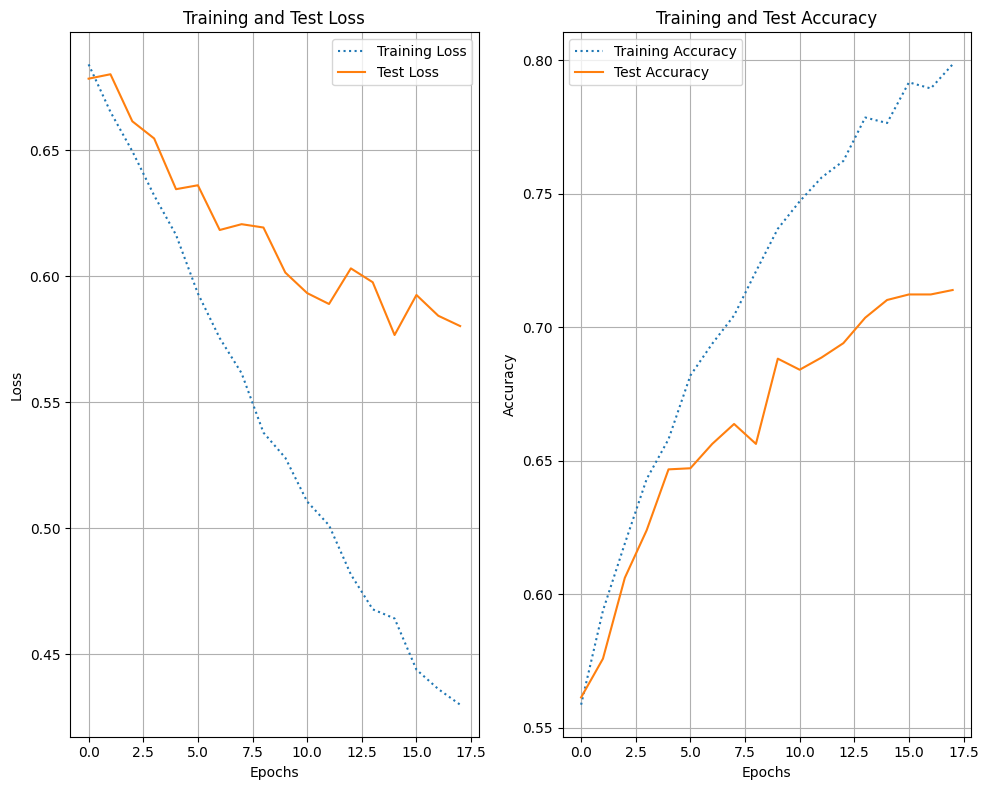

In [15]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8)) 

ax1.plot(tr_loss, label='Training Loss', linestyle=':')
ax1.plot(te_loss, label='Test Loss')
ax1.set_title('Training and Test Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# Plot Training and Test Accuracy
ax2.plot(tr_correct, label='Training Accuracy', linestyle=':')
ax2.plot(te_correct, label='Test Accuracy')
ax2.set_title('Training and Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()



6.Comment on line plots.

In [17]:
# YOUR CODE HERE
answer = """
The training loss steadily decreased from 0.684075 to 0.430019 over the epochs,while training accuracy improved from 55.86% to 79.84%. This suggests that the model is successfully learning and modifying its weights based on the training dataset. Such continuous enhancement in training metrics is anticipated as the model becomes increasingly adept at fitting the training data with each epoch.

The testing accuracy rose from 56.14% to a maximum of 71.39%. Although the testing loss initially declined, it began to rise again, which may indicate the onset of overfitting. This is further supported by the fact that while training accuracy continued to increase, the testing accuracy began to level off. The early stopping mechanism was effective, halting the training at epoch 18 to prevent further overfitting.

The gap between training and testing metrics reflects a generalization issue. While the training metrics indicate improved performance with each epoch, the testing metrics present a contrasting scenario. This discrepancy may arise from the model starting to memorize the training data, including its noise, thereby becoming less capable of generalizing to new, unseen data.
"""

# Model Training and Evaluation Analysis

## Training Metrics

- **Training Loss**: 
  - Decreased from **0.684075** to **0.430019**
  
- **Training Accuracy**: 
  - Improved from **55.86%** to **79.84%**

This steady improvement suggests that the model is **successfully learning** and modifying its weights based on the training dataset. Such continuous enhancement in training metrics is anticipated as the model becomes increasingly adept at fitting the training data with each epoch.

## Testing Metrics

- **Testing Accuracy**: 
  - Rose from **56.14%** to a maximum of **71.39%**
  
- **Testing Loss**: 
  - Initially declined but began to **rise again**, indicating the potential onset of **overfitting**.

### Key Observations

- While **training accuracy** continued to increase, **testing accuracy** began to **level off**. This discrepancy highlights a **generalization issue**.
- The early stopping mechanism was effective, halting the training at **epoch 18** to prevent further overfitting.

### Conclusion

The gap between training and testing metrics reflects a **generalization problem**:

- The training metrics indicate improved performance with each epoch.
- The testing metrics present a contrasting scenario, potentially due to the model starting to **memorize** the training data, including its **noise**, thereby becoming less capable of generalizing to new, unseen data.
